<a href="https://colab.research.google.com/github/Michael-HK/Mobile_Apps_Reccomendation_system/blob/main/mobile_Apps_reccomender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dependencies**

In [1]:
!pip install contractions
!pip install inflect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.8 MB/s eta 0:00:00


## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gzip
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import warnings
#%load_ext watermark
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten,Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# change directory to the folder
%cd /content/drive/My Drive/end_2_end_ML/music_recommendation

Mounted at /content/drive
/content/drive/My Drive/end_2_end_ML/music_recommendation


## Data Ingest

In [ ]:
#======== download datasets ================

!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android.json.gz

!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Apps_for_Android.json.gz


--2023-07-28 13:50:53--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299986290 (286M) [application/x-gzip]
Saving to: ‘reviews_Apps_for_Android.json.gz.5’

reviews_Apps_for_An 100%[===================>] 286.09M  50.4MB/s    in 5.9s    

2023-07-28 13:50:59 (48.3 MB/s) - ‘reviews_Apps_for_Android.json.gz.5’ saved [299986290/299986290]

--2023-07-28 13:50:59--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Apps_for_Android.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16414723 (16M) [application/x-gzip]
Saving to: ‘meta_Apps_for_Android.json.gz.5’

meta_

In [4]:
##======= function to read the file as dataframe =============================

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df1 = getDF('./reviews_Apps_for_Android.json.gz')
df2 = getDF('./meta_Apps_for_Android.json.gz')

In [5]:
#=== view

df1.head()
df2.head()

,asin,related,categories,salesRank,price
0,B004A9SDD8,"{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
1,B004AFQAUA,"{'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...","[[Apps for Android, Music, Music Players]]",NaN,NaN
2,B004AGCR1K,"{'also_viewed': ['B00A7W29BE', 'B00I5PB9UM', '...","[[Apps for Android, Productivity]]",NaN,NaN
3,B004AHBBPW,"{'also_bought': ['B006T2U1V6', 'B00FBCIYZU', '...","[[Apps for Android, Reference]]",NaN,NaN
4,B004ALFHV2,"{'also_bought': ['B00CA6LZAG', 'B00FE5ZF4W', '...","[[Apps for Android, Communication]]",NaN,NaN


In [6]:
print(df1.shape)
print(df2.shape)

(2638173, 9)
(61551, 5)


In [7]:
##======== number of products===========

df1['asin'].nunique()

#print('Total number of review Apps is: ', len(df1['asin'].nunique()))

61275

In [8]:
##========== merge the files===============

merged_dataset = pd.merge(df1, df2, on='asin', how='left')

In [9]:
merged_dataset.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,related,categories,salesRank,price
0,AUI0OLXAB3KKT,B004A9SDD8,A Customer,"[0, 0]",Glad to finally see this app on the android ma...,5.0,Great app!!!,1.301184e+09,"03 27, 2011","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
1,A1ZUSQ3TC3EC4C,B004A9SDD8,A. Lissak,"[12, 14]",this app works great on the Kindle Fire... kid...,5.0,Kid loves it,1.321574e+09,"11 18, 2011","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
2,AC05OAXD72X1V,B004A9SDD8,Allie,"[0, 0]",We love these monkey's and all the concepts th...,4.0,Love these monkeys!,1.367366e+09,"05 1, 2013","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
3,A2RVMFOKBVM21I,B004A9SDD8,Amazon Customer,"[0, 2]",cannot get my kindle away from my 2 year old g...,5.0,fun fun for toddlers,1.350173e+09,"10 14, 2012","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
4,A3NBSRGUWQGCMZ,B004A9SDD8,Amazon Customer,"[1, 3]",I start this app up whenever I forget what a f...,1.0,Might be great if it worked,1.300838e+09,"03 23, 2011","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
5,A2KTVCVZJ8GPD2,B004A9SDD8,A. Mclean,"[0, 0]",Very engaging to my three year old toddler. Sh...,5.0,Great video,1.393546e+09,"02 28, 2014","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
6,A2I9RREBHMMPCJ,B004A9SDD8,AngelaM,"[1, 2]","My daughter loves this app. Unfortunately, af...",3.0,great when it worked,1.305504e+09,"05 16, 2011","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
7,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1.383350e+09,"11 2, 2013","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
8,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1.323043e+09,"12 5, 2011","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN
9,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1.337558e+09,"05 21, 2012","{'also_bought': ['B006M3K874', 'B00F85SMOI', '...","[[Apps for Android, Kids]]",NaN,NaN


In [10]:
# check for null
merged_dataset.isnull().sum()


reviewerID              0
asin                    0
reviewerName       187320
helpful                 0
reviewText              0
overall                 0
summary                 0
unixReviewTime          1
reviewTime              0
related              2768
categories              0
salesRank         2635549
price             2617728
dtype: int64

In [11]:
def strg(ls):
  return ' '.join([str(e) for e in ls])


In [12]:
#=== obtain the main columns that are needed for our system ====================

#merge text column
merged_dataset['textinfo'] = merged_dataset['reviewText'] + ' ' + merged_dataset['summary'] + ' ' + merged_dataset['categories'].apply(strg)

df = merged_dataset[['reviewerID', 'asin', 'textinfo', 'overall']]
df.head()

,reviewerID,asin,textinfo,overall
0,AUI0OLXAB3KKT,B004A9SDD8,Glad to finally see this app on the android ma...,5.0
1,A1ZUSQ3TC3EC4C,B004A9SDD8,this app works great on the Kindle Fire... kid...,5.0
2,AC05OAXD72X1V,B004A9SDD8,We love these monkey's and all the concepts th...,4.0
3,A2RVMFOKBVM21I,B004A9SDD8,cannot get my kindle away from my 2 year old g...,5.0
4,A3NBSRGUWQGCMZ,B004A9SDD8,I start this app up whenever I forget what a f...,1.0


In [13]:
df.textinfo[0]

"Glad to finally see this app on the android market.  my wife has it on her iphone and ipad and my son (15 months) loves it!  Hopefully more apps like this are on the way! Great app!!! ['Apps for Android', 'Kids']"

In [14]:
##==== check for nan===================

df.isnull().sum()


reviewerID    0
asin          0
textinfo      0
overall       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2638173 entries, 0 to 2638172
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   reviewerID  object 
 1   asin        object 
 2   textinfo    object 
 3   overall     float64
dtypes: float64(1), object(3)
memory usage: 100.6+ MB


In [15]:
print(df.shape)

(2638173, 4)


<Axes: title={'center': 'Number of Reviews by top 50 customers'}>

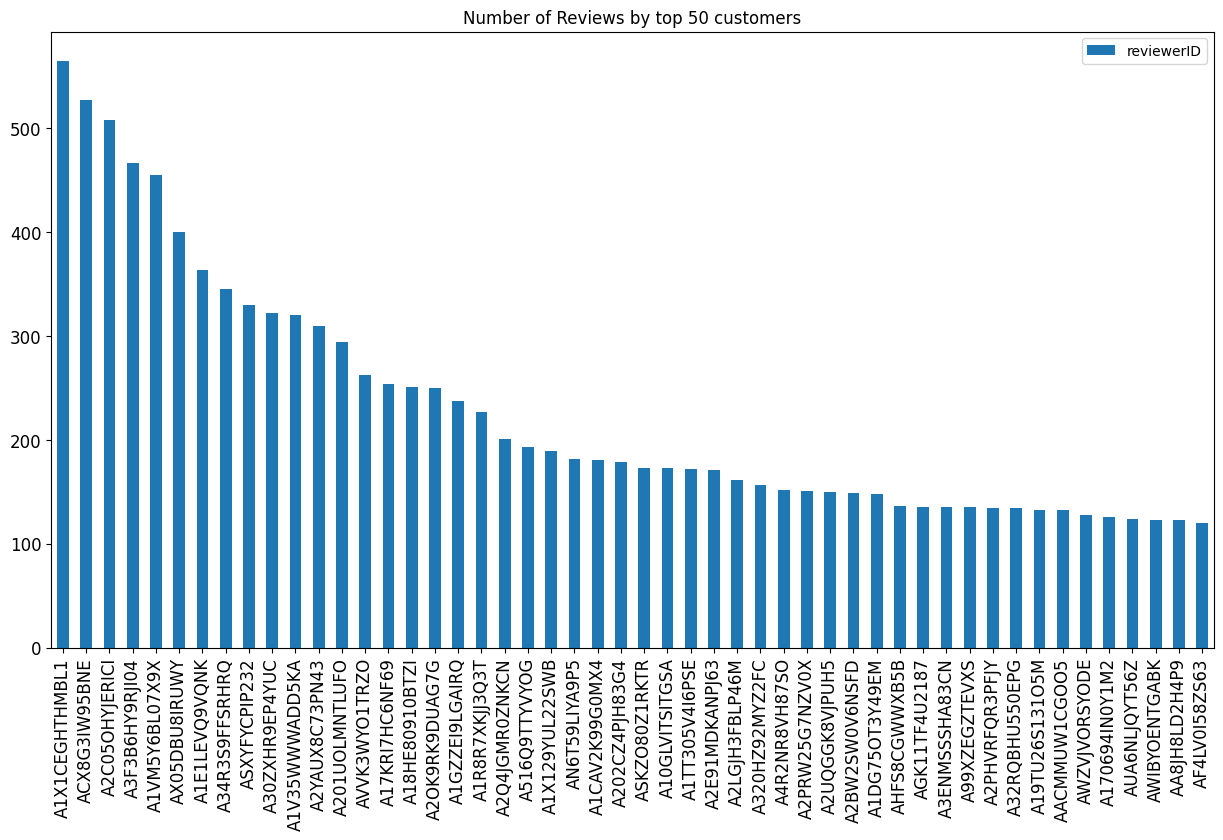

In [ ]:
df['reviewerID'].value_counts()[0:50].plot(kind='bar', title='Number of Reviews by top 50 customers',\
                                         legend=True, figsize=(15,8), fontsize=12)

<Axes: title={'center': 'Number of Reviews for top 50 Apps'}>

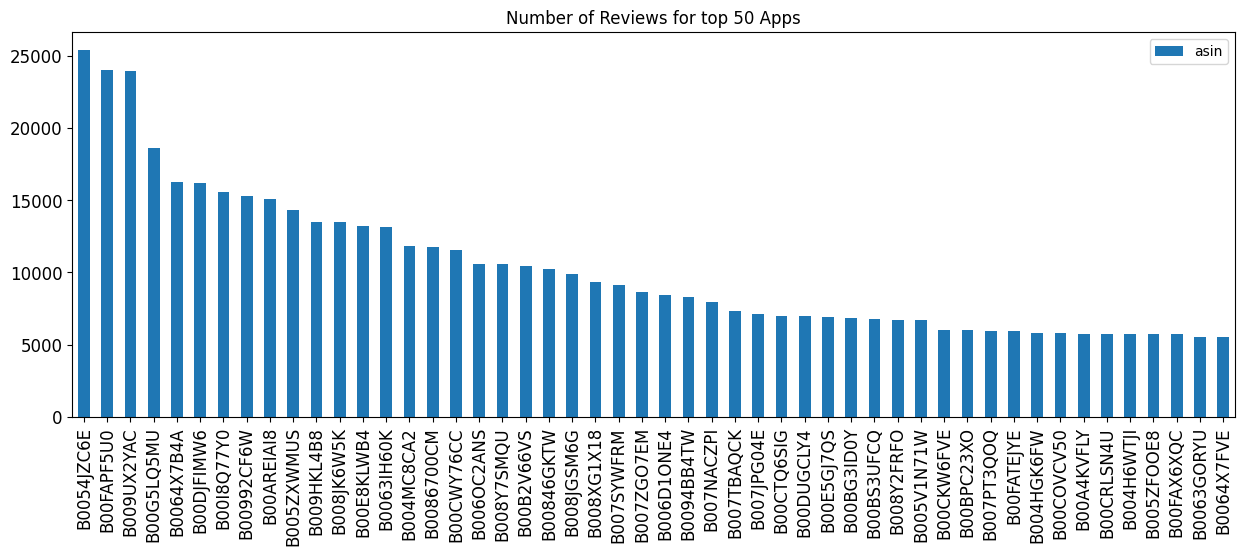

In [ ]:
df['asin'].value_counts()[0:50].plot(kind='bar', title='Number of Reviews for top 50 Apps',\
                                         legend=True, figsize=(15,5), fontsize=12)

In [ ]:
##======== Average ratings for the top 50 Apps ==============================

df2 = df.groupby(['asin'])
list_app_ratings = []
for apps,y in df2:
  list_app_ratings.append({'asin': apps, 'average_rating': y['overall'].mean(),\
                           'review_count':y.shape[0]})

In [ ]:
df_avg_rating = pd.DataFrame(list_app_ratings)
df_avg_rating_sorted = df_avg_rating.sort_values(by = 'review_count', ascending=False)

<Axes: title={'center': 'Average ratings for top 50 Apps'}, xlabel='asin'>

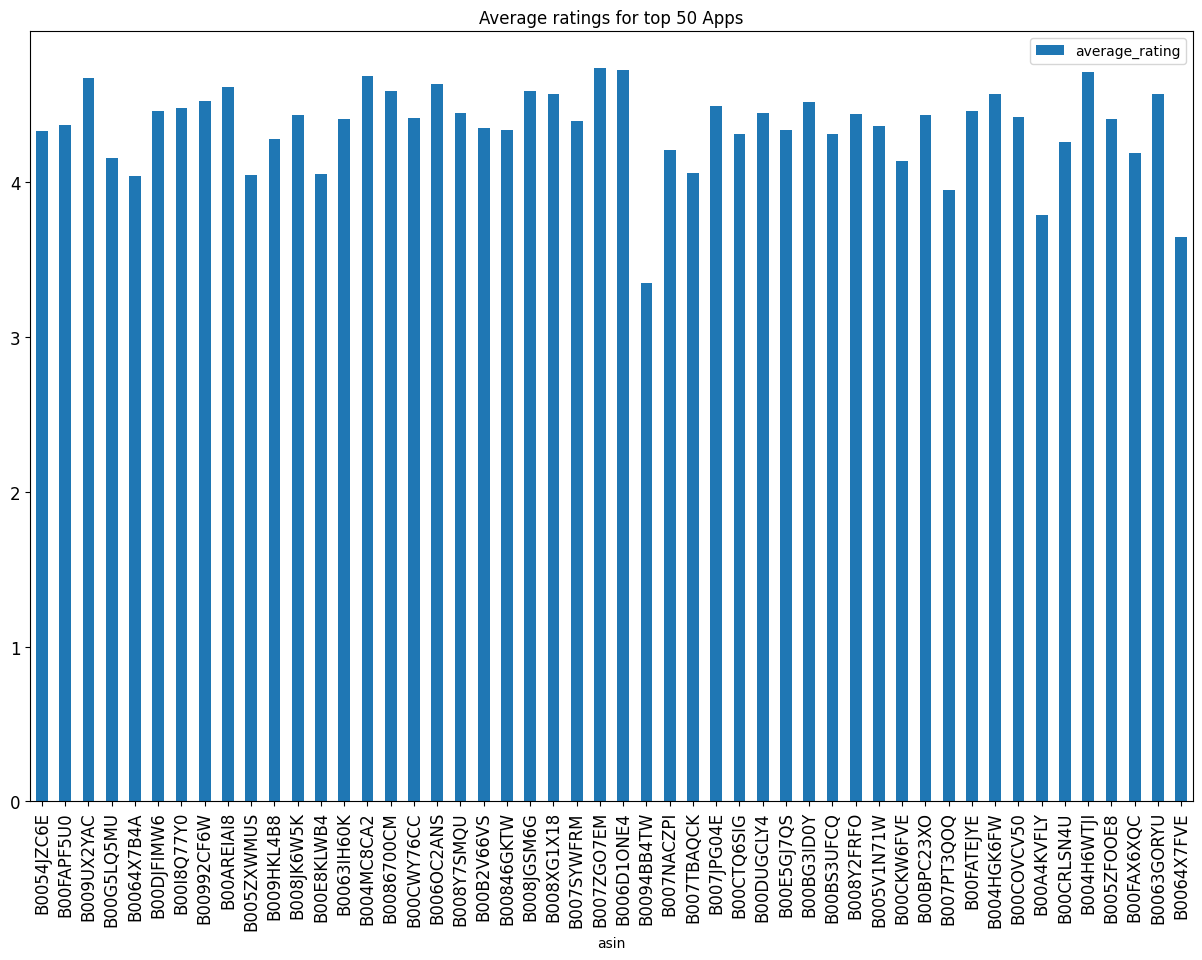

In [ ]:
df_avg_rating_sorted[['asin', 'average_rating']][0:50].plot(kind='bar', x='asin',\
                                                              title = 'Average ratings for top 50 Apps',\
                                                              figsize=(15,10), legend=True, fontsize=12)

<Axes: title={'center': 'Ratings Distribution'}, ylabel='overall'>

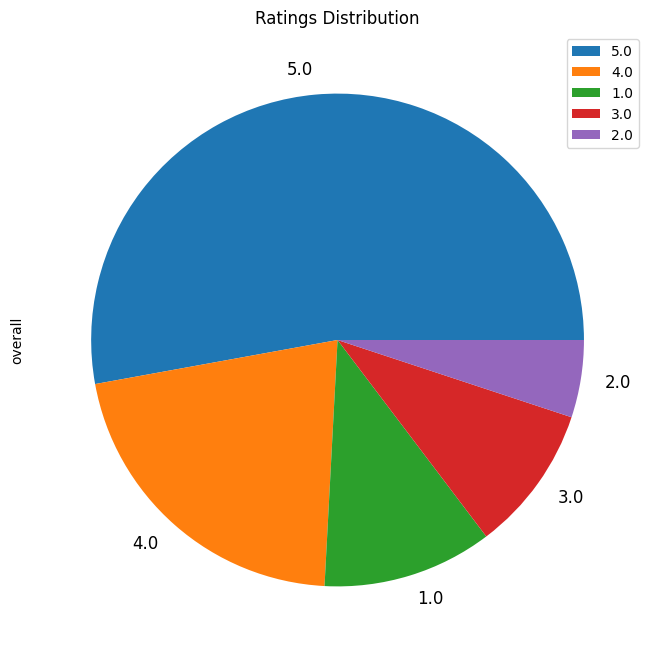

In [ ]:
df['overall'].value_counts().plot(kind='pie', title='Ratings Distribution',\
                                  figsize=(15,8), legend=True, fontsize=12)

In [16]:
print('numer of users/reviewers:')
print(df['reviewerID'].nunique())
print('number of android apps:')
print(df['asin'].nunique())

numer of users/reviewers:
1323884
number of android apps:
61275


In [16]:
##===== Due to hardware resource limitation, we will be using only 70% of the data for this model ===========

df = df.sample(frac=0.70)
df

,reviewerID,asin,textinfo,overall
1004957,A6FVVC7VYAS4R,B00846GMHW,fun and cool game. its a real time killer. it ...,5.0
1677277,A2ONBQL0UA0VSV,B00AUXZJAS,I would recommend this app. to anyone who is f...,4.0
737603,A3PN4N56T9ISK1,B0073LWEXK,This is a great game! It is longer than its pr...,5.0
2433501,A2C05OHYJERICI,B00GY0HJ4K,"Pretty much a Candy Crush rip off, Includes th...",1.0
1487980,A1C0RRDB3OQGGN,B009ZXRC9A,"The game was cool, but a little hard!!!!! But ...",5.0
...,...,...,...,...
1124448,A1VIAP2ID9932K,B008IVFIXC,big win mma.that'll be cool. please fix errors...,1.0
2426717,A2E5EH2L2VWWMH,B00GUY712U,I love the cute faces there so cut but there i...,5.0
1078141,A176SURVLN5ECB,B008AZGWYK,There are so many times over the years before ...,5.0
565388,A225JMB689O9WN,B0067VKQLE,If the Kindle is not charging then the kids or...,3.0


## Data preprocessing

In [17]:
## removing long tail, i.e users with lower than 5 occurences and products with lower than 10 occurences

import pandas as pd
from sklearn.preprocessing import LabelEncoder

def prepare_train_data(df):
    # frequency of occurence
    reviewers = df['reviewerID'].value_counts()
    products = df['asin'].value_counts()

    # Filter the DataFrame to include only interactions involving customers and products with at least five ratings.
    reviewers = reviewers[reviewers >= 5]
    products = products[products >= 5]

    reduced_df = df[df['reviewerID'].isin(reviewers.index) & df['asin'].isin(products.index)]

    # Use LabelEncoder to generate unique indices for 'customer_id'
    customer_encoder = LabelEncoder()
    reduced_df['user_id'] = customer_encoder.fit_transform(reduced_df['reviewerID'])

    # Use LabelEncoder to generate unique indices for 'product_id' (item column)
    product_encoder = LabelEncoder()
    reduced_df['Apps_id'] = product_encoder.fit_transform(reduced_df['asin'])

    return reduced_df

In [18]:

#=========Print the optimized DataFrame=======
data_df = prepare_train_data(df)

data_df

,reviewerID,asin,textinfo,overall,user_id,Apps_id
2433501,A2C05OHYJERICI,B00GY0HJ4K,"Pretty much a Candy Crush rip off, Includes th...",1.0,19039,16176
1704354,AQWUXKCQD78XH,B00B2V66VS,Better than Temple Run. More play options. Gat...,5.0,50402,10917
307773,AQY0ESG2RI042,B0054JZC6E,great games with wide variety of choices to pl...,3.0,50414,1899
919600,AGEYCHA416RX2,B007U8JRWW,i think its creepy because you have to think a...,3.0,46242,6025
2092203,A1KKNDVMW7AIEL,B00DRPVE3M,I Have always loved playing Uno in it's many f...,4.0,8134,13689
...,...,...,...,...,...,...
2530951,A233IZSRZRL2CL,B00I8Q77Y0,The app is surprising good. I thought it was g...,5.0,15461,17126
2290410,A6AWX1Y3MOH0W,B00FATEJYE,"console edition was perfect, then they put a k...",5.0,42168,15075
2426717,A2E5EH2L2VWWMH,B00GUY712U,I love the cute faces there so cut but there i...,5.0,19890,16119
1078141,A176SURVLN5ECB,B008AZGWYK,There are so many times over the years before ...,5.0,2887,7055


In [19]:
data_df['overall'].astype(int)
data_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 428775 entries, 2433501 to 565388
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewerID  428775 non-null  object 
 1   asin        428775 non-null  object 
 2   textinfo    428775 non-null  object 
 3   overall     428775 non-null  float64
 4   user_id     428775 non-null  int64  
 5   Apps_id     428775 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 22.9+ MB


In [20]:
print('number of apps: ', data_df['asin'].nunique())
print('number of users/reviewers: ', data_df['reviewerID'].nunique())

number of apps:  18333
number of users/reviewers:  54024


### Text preprocessing

### Text cleaning and curating

In [21]:
import contractions
import inflect
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer
from multiprocessing import Pool, cpu_count
from functools import partial

# Download nltk data
nltk.download('stopwords')
nltk.download('punkt')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
# Expand contractions
def contract(text):
    tokens = text.split()
    tokens = [contractions.fix(token) for token in tokens]
    text = " ".join(tokens)
    return text

def remove_stopwords(text):
   # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    text = " ".join(tokens)
    return text

def p_stem(text):
    stemmer = PorterStemmer()
    tokens = text.split()
    tokens = [stemmer.stem(token) for token in tokens]
    text = " ".join(tokens)
    return text


### **Text column cleaning**

In [23]:

##========================clean data============================================
data_df['textinfo'] = data_df['textinfo'].apply(contract)
data_df['textinfo'] = data_df['textinfo'].apply(remove_stopwords)
data_df['textinfo'] = data_df['textinfo'].apply(p_stem)

#============== Tokenize and pad apps descriptions==============================

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data_df['review'])
# data_df['reviewText'] = tokenizer.texts_to_sequences(data_df['reviewText'])


In [ ]:

# #======================pad sequence=============================================
# max_sequence_length = max(len(seq) for seq in data_df['reviewText'])
# print('maximum sequence length is:', max_sequence_length)

# data_df['reviewText'] = pad_sequences(data_df['reviewText'], maxlen=max_sequence_length)

# #========== pickle cleaned data ================================================
# pickle.dump(data_df.to_dict(), open('apps_dict.pkl', 'wb'))   #save_cleaned data

In [24]:
#================Split the data into train and test sets========================
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42)

In [25]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)



## **Building Model(s)**

### Wide_deep_model

In [ ]:
############### Building Model ======================

def wide_deep_model(apps, max_sequence_length):
    """Define input layers"""

    reviewerID = Input(shape=(1,), name='reviewerID')
    asin = Input(shape=(1,), name='asin')
    tags = Input(shape=(max_sequence_length,), name='reviews')

    # Embedding layers for reviewerID and asin
    id_embedding = Embedding(input_dim=apps['reviewerID'].nunique(), output_dim=10, input_shape=(1,))(reviewerID)
    title_embedding = Embedding(input_dim=apps['asin'].nunique(), output_dim=10, input_shape=(1,))(asin)

    # Flatten the embedding layers
    id_flatten = Flatten()(id_embedding)
    title_flatten = Flatten()(title_embedding)

    # Concatenate the flattened embeddings
    concatenated = Concatenate()([id_flatten, title_flatten])

    # Deep component
    bn_concat = BatchNormalization()(concatenated)
    fc1 = Dense(256, use_bias=False, activation='relu')(bn_concat)
    bn1 = BatchNormalization()(fc1)
    fc1 = Dropout(rate=0.2)(bn1)

    fc2 = Dense(128, use_bias=False, activation='relu')(fc1)
    bn2 = BatchNormalization()(fc2)
    fc2 = Dropout(rate=0.2)(bn2)

    fc3 = Dense(64, use_bias=False, activation='relu')(fc2)
    bn3 = BatchNormalization()(fc3)
    fc3 = Dropout(rate=0.2)(bn3)

    deep_output = Dense(64, activation='relu')(fc3)

    # Fully connected layers for the wide component
    wide_output = Concatenate()([tags, deep_output])
    wide_output = Dropout(rate=0.2)(wide_output)
    wide_output = Dense(1)(wide_output)

    # Model
    model = Model(inputs=[reviewerID, asin, tags], outputs=wide_output)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model


#### Train wide-deep-model

In [ ]:
model = wide_deep_model(apps, max_sequence_length)

train_reviewerID = train_data['user'].values
train_asin = train_data['App'].values
train_tags = train_data['reviewText'].values # exclude text information

#===Train the model
model.fit(
    x=[train_reviewerID, train_asin],
    y=train_data['overall'],
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks = [checkpointer, callback_custom, TensLog, CSVlog, reduce_lr]
)

### Matrix Factorization model

In [26]:
import tensorflow as tf
import numpy as np

tf.config.run_functions_eagerly(True)

all_users = data_df['user_id'].unique()
all_apps = data_df['Apps_id'].unique()

##=============== Model ======================

#users
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users, name="user_as_integer")(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32, name="user_embedding")(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1, name="user_bias")(user_as_integer)

#Apps embedding
apps_input = tf.keras.layers.Input(shape=(1,), name="Apps")
apps_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_apps, name="apps_as_integer")(apps_input)
app_embedding = tf.keras.layers.Embedding(input_dim=len(all_apps) + 1, output_dim=32, name="app_embedding")(apps_as_integer)
app_bias = tf.keras.layers.Embedding(input_dim=len(all_apps) + 1, output_dim=1, name="app_bias")(apps_as_integer)

#matrix factorization implementation
dot = tf.keras.layers.Dot(axes=2, name="dot_product")([user_embedding, app_embedding])
add = tf.keras.layers.Add(name="sum")([dot, user_bias, app_bias])
flatten = tf.keras.layers.Flatten(name="flatten")(add)
squash = tf.keras.layers.Lambda(lambda x: 4 * tf.nn.sigmoid(x) + 1, name="squash")(flatten)

model = tf.keras.Model(inputs=[user_input, apps_input], outputs=squash)

model.compile(loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])


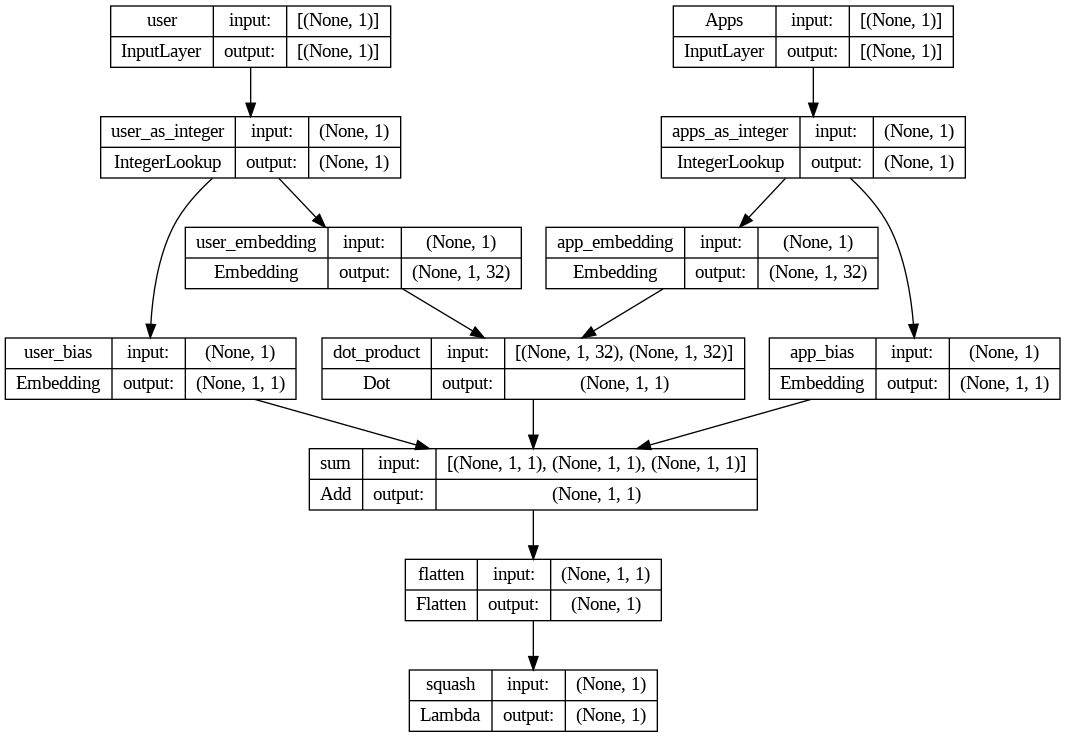

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger, TensorBoard
import os

#========callbacks function=====================================================
#path_checkpoint = "training_1/cp.ckpt"
#directory_checkpoint = os.path.dirname(path_checkpoint)

checkpointer = ModelCheckpoint("Recommender_system.hdf5", verbose=1, monitor='val_loss',
                               mode='min', save_best_only=True)

callback_custom = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                   verbose=1, patience=10, restore_best_weights=True)

#==========learning_rate regulation during training=============================

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, patience=10, verbose=1,
                              min_delta=1e-4, cooldown=2, min_lr=1e-6)

#======Tensorboard visualization=========
TensLog = TensorBoard(log_dir='./log_dir')

#=====Callback that streams epoch results to a CSV file.
csv_file = 'recoment_training.csv'
CSVlog = CSVLogger(csv_file)

#### **Train matrix factorization model**

In [33]:


#y=train_data['overall']
model.fit(
    x={"user": train_data["user_id"], "Apps": train_data['Apps_id']},
    y=train_data['overall'].values,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    callbacks=[checkpointer, callback_custom, TensLog, CSVlog, reduce_lr],
)


Epoch 1/50
2143/2144 [============================>.] - ETA: 0s - loss: 2.4707 - mean_absolute_error: 1.4249
Epoch 1: val_loss improved from inf to 2.27883, saving model to Recommender_system.hdf5
2144/2144 [==============================] - 102s 47ms/step - loss: 2.4706 - mean_absolute_error: 1.4249 - val_loss: 2.2788 - val_mean_absolute_error: 1.3594 - lr: 0.0010
Epoch 2/50
2144/2144 [==============================] - ETA: 0s - loss: 2.1305 - mean_absolute_error: 1.3011
Epoch 2: val_loss improved from 2.27883 to 2.06417, saving model to Recommender_system.hdf5
2144/2144 [==============================] - 97s 45ms/step - loss: 2.1305 - mean_absolute_error: 1.3011 - val_loss: 2.0642 - val_mean_absolute_error: 1.2693 - lr: 0.0010
Epoch 3/50
2143/2144 [============================>.] - ETA: 0s - loss: 1.9471 - mean_absolute_error: 1.2211
Epoch 3: val_loss improved from 2.06417 to 1.94450, saving model to Recommender_system.hdf5
2144/2144 [==============================] - 98s 46ms/step -

In [ ]:
#!ls {directory_checkpoint}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


### Evaluate trained Model

In [34]:
model.evaluate(x={"user": test_data["user_id"], "Apps": test_data["Apps_id"]}, y=test_data["overall"])

2680/2680 [==============================] - 50s 19ms/step - loss: 1.6572 - mean_absolute_error: 1.0454


[1.6571650505065918, 1.0454026460647583]

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#load model
model = tf.keras.models.load_model('Recommender_system.hdf5')
#=== evaluate on test data
#test_preds = []
#for array in np.array_split(test_data[['user_id', 'Apps_id']].values, 40):

    #test_preds += model.predict([array[:,0].to_list(), array[:,1].to_list()])
#test_preds += model.predict({"user": array[:,0], "Apps": array[:,1]}, verbose=0)
test_preds = model.predict({"user": test_data["user_id"], "Apps": test_data["Apps_id"]}, verbose=0)
test_preds = np.array(test_preds)
print("Mean Squared Error (MSE):", mean_squared_error(test_data['overall'], test_preds))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(test_data['overall'], test_preds)))
print("Mean Absolute Error (MAE):", mean_squared_error(test_data['overall'], test_preds))
print("R-squared (R2) score:", r2_score(test_data['overall'], test_preds))


Mean Squared Error (MSE): 1.6571652392725031
Root Mean Squared Error (RMSE): 1.2873093020997335
Mean Absolute Error (MAE): 1.6571652392725031
R-squared (R2) score: 0.11039594556407761


In [ ]:
##++++++++++ Evaluate ++++++++++++++

# test_preds = []
# for array in np.array_split(test_df[['user_id', 'Apps_id']].values, 40):
#     test_preds += predictor.predict(json.dumps(json.dumps({'customer_id':array[:,0].to_list(),
#                                                             'product_id': array[:,1].to_list()})))

# test_preds - np.array(test_preds)
# print('MSE', np.mean((test_df['start_ratings']-test_preds))**2)

## Real-time prediction

In [ ]:

def user_recommendation(user_id):
    predictions_user = []
    for array in np.array_split(data_df['Apps_id'].values, 40):
        prediction_user += predictor.predict(json.dump({'customer_id': customer_index[customer_index['user']==8]\
                                                        .values.tolist()*array.shape[0],
                                                        'product_id':array.tolist()}))

    predictions = pd.DataFrame({'product_id':product_index['product_id'],
                                'prediction':predictions})


## Recommendation based on likes or view

In [ ]:
## The input into cv i.e apps['tags'] must be a clean text data

cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(data_df['textinfo']).toarray()

#vectors
similarity = cosine_similarity(vectors)    # for similarity evaluation

In [ ]:
##======= save model ===================
pickle.dump(data_df.to_dict(), open('apps_dict.pkl', 'wb'))   #save_cleaned data
pickle.dump(similarity, open('similarity.pkl', 'wb'))

pickle.dump(model, open('Recommend_model.pkl', 'wb'))

In [ ]:
# Reccomendation Model evaluation function

k_values = [5, 10, 15, 20]

for k in k_values:
  pre, re = precision_recall_at_k(model, test_data, k=k)
  print('Proposed Reccomendation system Evaluation')
  print(f'The average precision and average recall at {k} are {pre} and {re}, respectively')

In [ ]:
#=========== Recommendation system =============================================

def app_recommend(Apps_df, similarity, appID):
  """load save model"""
 # Apps_df = joblib.load('apps_dict.pkl')
 # similarity = joblib.load('similarity.pkl')

  apps_index = Apps_df[Apps_df['asin'] == appID].index[0]
  distances = similarity[apps_index]
  apps_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:6]

  for i in apps_list:
    print(Apps_df.iloc[i[0]].asin)

In [ ]:
import numpy as np

def Apps_recommendations(model, data, user_id, k=5):
    """ Apps reccomendation based on users record"""

    # Create sequences of apps descriptions for the user
    user_apps_reviews = data.loc[data['reviewerID'] == user_id, 'tags']                ## data need to be changed "tags":apps reviews
    #user_sequences = tokenizer.texts_to_sequences(user_apps_reviews)
    user_padded_sequences = pad_sequences(user_sequences, maxlen=max_sequence_length)

    # Prepare input data for the model
    user_input = np.full_like(user_padded_sequences, user_id)                           #to ensure userID as the same numbers with other input
    asin_input = data.loc[data['reviewerID'] == user_id, 'asin'].values                 #encoded apps ID

    # Get apps ID and description indices with highest predicted ratings
    predictions = model.predict([user_input, asin_input, user_padded_sequences]).flatten()  # input: userID, AppsID, tokenised & vectorised apps reviews
    top_k_indices = np.argsort(predictions)[::-1][:k]

    # Get the andriod Apps recommendation for the top-k recommendations
    top_k_asins = data.loc[top_k_indices, 'asin'].values

    asin_encoder = joblib.load('id_encoder.pkl')

    top_k_AppsID = asin_encoder.inverse_transform(top_k_asins)

    #top_k_movie_titles = data.loc[data['asin'].isin(top_k_asins), 'movie_title'].values

    return top_k_AppsID

# Example usage to get movie recommendations for user with ID 123
#user_id = 123
#recommendations = Apps_recommendations(model, user_id)
#print(f"Apps recommendations for user {user_id}:")
#print(recommendations)


## Integrated Reccomendation Model based on User Records and current view/likes

In [ ]:
import joblib

class Apps_Reccomendation_Model():
  def __init__(self):
    self.data = joblib.load('data_df.pkl')
    self.model = joblib.load('Recommend_model.pkl')
    self.Apps_df = joblib.load('apps_dict.pkl')
    self.similarity = joblib.load('similarity.pkl')

  def integral_recommend(self, userID: None, appID:None):
    if userID is not None and appID is None:
      print('Reccommended apps based on your previous record')
      reccomend = Apps_recommendations(self.model, self.Apps_df, userID, k=5)
      print(reccomend)

    elif userID is None and appID is not None:
      print('Reccommended items based on current view/likes:')
      app_recommend(self.Apps_df, self.similarity, appID)

    elif userID is not None and appID is not None:
      print('Reccommended items based on current view/likes:')
      app_recommend(self.Apps_df, self.similarity, appID)

      print('Reccommended apps based on your previous download')
      reccomend = Apps_recommendations(self.model, userID, k=5)
      print(reccomend)
    else:
      print('provide your ID or view one of the apps')

## others (not needed)

In [ ]:
# Reccomendation Model evaluation

def precision_recall_at_k(test_data, model, k=5):
    precision_sum = 0
    recall_sum = 0

    for user_id in test_data['reviewerID'].unique():
        user_apps = test_data[test_data['reviewerID'] == user_id]['asin'].values
        user_predictions = Apps_recommendations(model, user_id, k=k)

        # Calculate intersection (retrieved items that are relevant)
        intersection = len(set(user_apps) & set(user_predictions))

        # Calculate precision and recall for this user
        precision = intersection / min(k, len(user_apps))
        recall = intersection / len(user_apps)

        precision_sum += precision
        recall_sum += recall

    # Calculate average precision and recall across all users
    avg_precision = precision_sum / len(test_data['reviewerID'].unique())
    avg_recall = recall_sum / len(test_data['reviewerID'].unique())

    return avg_precision, avg_recall


In [ ]:
# import numpy as np

# def Apps_rec_MFB(model, data, user_id, k=5):
#     """ Apps reccomendation based on users record"""

#     # locate user uniq_ID
#     user_uniq = data.loc[data['reviewerID'] == user_id, 'user']

#     # Prepare input data for the model
#     user_input = np.full_like(user_padded_sequences, user_id)

#     #obtain app_uniq ID
#     app_id = data.loc[data['reviewerID'] == user_id, 'app'].values

#     # Get apps ID and description indices with highest predicted ratings
#     predictions = model.predict([user_input, asin_input, user_padded_sequences]).flatten()
#     top_k_indices = np.argsort(predictions)[::-1][:k]

#     # Get the andriod Apps recommendation for the top-k recommendations
#     top_k_asins = data.loc[top_k_indices, 'asin'].values
#     top_k_ratings = data.loc[top_k_indices, 'asin'].values
#     return top_k_AppsID


In [ ]:
#==== Flask for exposing the model to web server ================

# @app.route('/predict', methods=['GET', 'POST'])
#   def predict():
#     model = Apps_Reccomendation_Model()
#     if request.method == 'POST':
#       input = request.json()
#       result = model.integral_recommend(input)
#       return jsonify(result)

In [ ]:
# def preprocess_text(text):
#     # Lowercase
#     text = text.lower()

#     # Remove special characters
#     text = re.sub(r"[^a-zA-Z0-9]", " ", text)
#     text = re.sub(r'(@|#)\w+', '' , text)
#     text = re.sub("[,.]", "", text)
#     text = re.sub(r'https?://\S+', '' , text)
#     text = re.sub(r'(\?|!)+' , '', text)
#     text = re.sub(r"\(|\)", "", text)
#     text = re.sub(r'(^\s+)' , '', text)
#     text = re.sub(r'(\s+$)' , '', text)
#     text = re.sub(r'\d+' , '', text)

#     # Expand contractions
#     tokens = text.split()
#     tokens = [contractions.fix(token) for token in tokens]
#     text = " ".join(tokens)

#     # Remove stopwords
#     stop_words = set(stopwords.words("english"))
#     tokens = text.split()
#     tokens = [token for token in tokens if token not in stop_words]
#     text = " ".join(tokens)

#     # Perform stemming
#     stemmer = PorterStemmer()
#     tokens = text.split()
#     tokens = [stemmer.stem(token) for token in tokens]
#     text = " ".join(tokens)

#     # # Convert numeric values to text expressions
#     # p = inflect.engine()
#     # tokens = text.split()
#     # tokens = [p.number_to_words(token) if token.isdigit() else token for token in tokens]
#     # text = " ".join(tokens)

#     return text

# def preprocess_text_parallel(text):
#     return preprocess_text(text)

# def re_preprocess_data(data, num_processes=None):
#     if num_processes is None:
#         num_processes = cpu_count()

#     if isinstance(data, (str, np.ndarray)):
#         return preprocess_text(data)

#     elif isinstance(data, (list, pd.Series)):
#         with Pool(processes=num_processes) as pool:
#             preprocessed_data = pool.map(preprocess_text_parallel, data)
#         return np.array(preprocessed_data)

#     elif isinstance(data, pd.DataFrame):
#         # Preprocess text columns in a DataFrame using parallel processing
#         with Pool(processes=num_processes) as pool:
#             func = partial(preprocess_text_parallel)
#             preprocessed_data = pool.map(func, data.values.flatten())
#             preprocessed_data = np.array(preprocessed_data).reshape(data.shape)
#             preprocessed_data = pd.DataFrame(preprocessed_data, columns=data.columns)
#         return preprocessed_data
#     else:
#         raise ValueError("Input data must be a string, column series, array, or a DataFrame.")

In [ ]:
# class MatrixFactorization(tf.keras.Model):
#     def __init__(self, num_users, num_items, num_emb=10, dropout_rate=0.2):
#         super(MatrixFactorization, self).__init__()
#         self.num_users = num_users
#         self.num_items = num_items
#         self.num_emb = num_emb
#         self.dropout_p = dropout_rate
#         xavier_init = tf.keras.initializers.GlorotNormal()
#         # user_input = tf.keras.layers.Input(shape=(1,), name="user")
#         # user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)


#         self.user_embeddings = tf.keras.layers.Embedding(self.num_users, self.num_emb,
#                                                          embeddings_initializer=xavier_init,
#                                                          embeddings_regularizer=tf.keras.regularizers.l2(0.01))

#         self.item_embeddings = tf.keras.layers.Embedding(self.num_items, self.num_emb,
#                                                          embeddings_initializer=xavier_init,
#                                                          embeddings_regularizer=tf.keras.regularizers.l2(0.01))
#         self.dropout = tf.keras.layers.Dropout(rate=self.dropout_p)
#         self.user_dense_layer = tf.keras.layers.Dense(units=self.num_emb, activation='relu')
#         self.item_dense_layer = tf.keras.layers.Dense(units=self.num_emb, activation='relu')

#     def call(self, inputs):
#         user_ids, item_ids = inputs
#         a = self.user_embeddings(user_ids)
#         a = self.user_dense_layer(a)

#         b = self.item_embeddings(item_ids)
#         b = self.item_dense_layer(b)

#         dot_product = tf.reduce_sum(tf.multiply(self.dropout(a), self.dropout(b)), axis=1)
#         return dot_product
# Create the model
num_users = data_df['user_id'].shape[0]
num_items = data_df['Apps_id'].shape[0]

model = MatrixFactorization(num_users = num_users, num_items = num_items, num_emb=64, dropout_rate=0.5)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
# train_reviewerID = train_data['user_id'].values
# train_asin = train_data['Apps_id'].values

# #===Train the model
# model.fit(
#     x=[train_reviewerID, train_asin],
#     y=train_data['overall'],
#     epochs=50,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks = [checkpointer, callback_custom, TensLog, CSVlog, reduce_lr]
# )


# # Example prediction for user_id=5 and item_id=10
# user_id = np.array([5])
# item_id = np.array([10])
# predicted_rating = model.predict([user_id, item_id])
# print("Predicted rating for user_id 5 and item_id 10:", predicted_rating[0])

In [ ]:
##=== save the model architecture with the best weight==========
My_model = MatrixFactorization(num_users = num_users, num_items = num_items,
                               num_emb=64, dropout_rate=0.2)     #instantiate model

My_model.load_weights(path_checkpoint)                                                                          # save integrated model with best weights


#save the model into workspace
!mkdir -p saved_model

My_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

My_model.fit(
    x=[train_reviewerID, train_asin],
    y=train_data['overall'],
    epochs=1,
    batch_size=32,
    validation_split=0.2
)
#model.fit(self.window.train, epochs=1,
#          validation_data=self.window.val)

#model.save('custom_model')
My_model.save('saved_model/Rec_model')